## Crypto Currency and Portfolio Construction

- Ryan Milgrim and Roo Fernando
- University of Washington
- CFRM 521: Machine Learning
- June, 3, 2024

### 1. Project Design [20 Points]

- Clear and Percise Problem Statement
- Reasonable Project Goal
- Extra credit of up to 10 points will be given for innovative content

#### Problem Statement

Cryptocurrency markets, first introduced in 2009, have seen widespread adoption despite their speculative nature. Traditional investment strategies are typically grounded in economic fundamentals such as company earnings and market interest rates. However, applying these principles to cryptocurrencies is challenging due to their decentralized nature, lack of ties to any single entity, and extreme price volatility. This has made constructing and managing cryptocurrency portfolios particularly difficult for traditional investors.

In this project, we aim to develop cryptocurrency strategies and portfolios through machine learning which could yield improvements to a static portfolio's risk or return profile. By leveraging these techniques, we seek to provide investors with tools to navigate highly volatile cryptocurrency markets.

#### Project Goal

The goal of our project is to develop a machine learning model capable of dynamically adjusting a cryptocurrency portfolio using historical prices and additional derived features. Our models may predict a coin's price / return on t+n or simply which coint will yield the highest return via binary classification. Using these predictions, we aim to construct a hypothetical portfolio which an investor could hold. To evaluate the success or failure of our models, we will employ the standard MSE / Accuracy metrics, but also compare our portfolios' performance against a static portfolio. 

Initially we aimed for this portfolio to be the maximum sharpe ratio portfolio (optimized through CVXPY), however, we have reduced this in complexity. The benchmark we will use is a 100% allocation to which ever coin yielded the highest return over the training set. Our reasoning for this high benchmark, is that a strategy which outperforms the best returning coin, would indicate market timing, in other words, superior navigation of crypto currency markets. 

### 2. Data Processing and Feature Engineering  [25 Points]

#### Reliable and relevant data sources

The data we will be using for our analysis can be found here: <a href="https://www.kaggle.com/code/adityamhaske/crypto-currencies-price-analysis">Kaggle - Crypto Currencies Price Analysis</a>. We have consolidated the four CSV files into a single data.csv file to streamline our notebook. 

The dataset includes historical open, high, low, and closing prices for BTC, ETH, LTC, and XRP from January 1, 2018. Our analysis primarily relies on closing prices to calculate daily returns and other features.

It's important to note that our dataset contains some missing values due to exchange issues. Instead of discarding these rows, we have opted to fill missing prices with the last known price, as this method minimizes data loss and maintains the integrity of our time series.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the datafile and format as a time series.
data = pd.read_csv('data.csv', index_col=1)
data.index = pd.to_datetime(data.index)#, format='mixed')

# Format the dataset into features denoted as {Coin}__{Feature}
data = data.set_index(['Crypto'], append=True).unstack()
data.columns = [f'{coin}__{ohlc}' for ohlc, coin in data.columns.values]

# Sorting the timeseries by date and imputing missing values. 
data.sort_index()
data = data.ffill()
data.head()

C:\Users\ryanm\AppData\Local\Temp\ipykernel_37776\2703395545.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.index = pd.to_datetime(data.index)#, format='mixed')


,BTC__Open,ETH__Open,LTC__Open,XRP__Open,BTC__High,ETH__High,LTC__High,XRP__High,BTC__Low,ETH__Low,LTC__Low,XRP__Low,BTC__Close,ETH__Close,LTC__Close,XRP__Close
Date,,,,,,,,,,,,,,,,
2018-01-01,13996.0,744.39,230.32,1.99,14035.0,772.98,237.77,2.10,12860.0,725.10,217.87,1.82,13535.0,757.01,225.63,2.10
2018-01-02,13535.0,758.00,225.34,2.07,15217.0,879.90,265.00,2.22,12956.0,757.01,225.01,1.93,14770.0,864.00,254.60,2.21
2018-01-03,14770.0,861.99,254.60,2.20,15394.0,947.92,261.49,2.90,14589.0,851.00,240.51,2.19,15057.0,938.00,243.00,2.78
2018-01-04,15057.0,937.18,243.01,2.78,15395.0,988.99,246.92,3.35,14225.0,905.01,225.00,2.34,14921.0,942.04,240.00,2.60
2018-01-05,14921.0,942.04,239.99,2.60,16909.0,1009.84,260.00,3.00,14817.0,900.00,236.00,2.15,16828.0,958.00,240.45,2.65


#### Reasonable data cleaning and preprocessing

For our analysis, we create an additional feature named "Return" representing the day of day change in closign price. To ensure that our dataset is formatted well and free of errors, we visualize the dataset with the below code chunk. 

The code generates a histogram of daily returns and a time series plot of closing prices. Upon reviewing these visualizations, we noticed an unusual pattern in the histogram for XRP. Further inspection revealed that the dataset contains only two decimal places of precision for XRP, which often trades below $1.00. This lack of precision results in XRP frequently showing a 0% daily return.

To address this issue, we have decided to exclude XRP from our analysis and focus on the remaining three cryptocurrencies: BTC, ETH, and LTC

In [2]:
def plot_returns_and_prices(coin, returns, prices):
    """Simple Plot Function to visualize the quality of our data"""

    # Making the plot
    fig, ax = plt.subplots(2, 1)
    returns.hist(bins=100, ax=ax[0])
    prices.plot(ax=ax[1])

    # Apply titles
    ax[0].set_title('Daily Returns')
    ax[1].set_title('Closing Prices')

    # Apply Grids for both plots
    ax[0].grid(True, alpha=0.7, linestyle='--')
    ax[1].grid(True, alpha=0.7, linestyle='--')

    # Apply title and layout
    fig.suptitle(coin)
    plt.tight_layout()

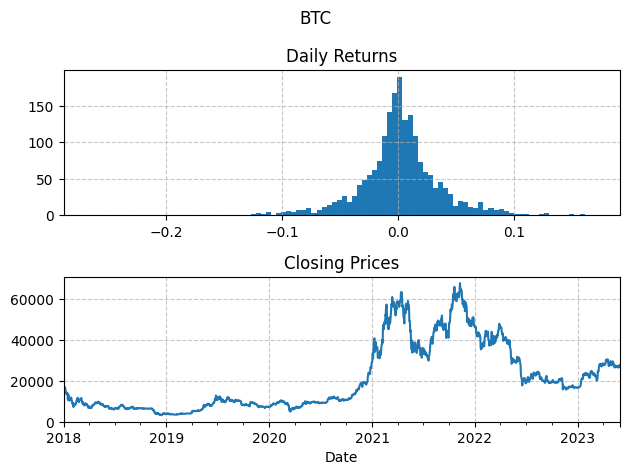

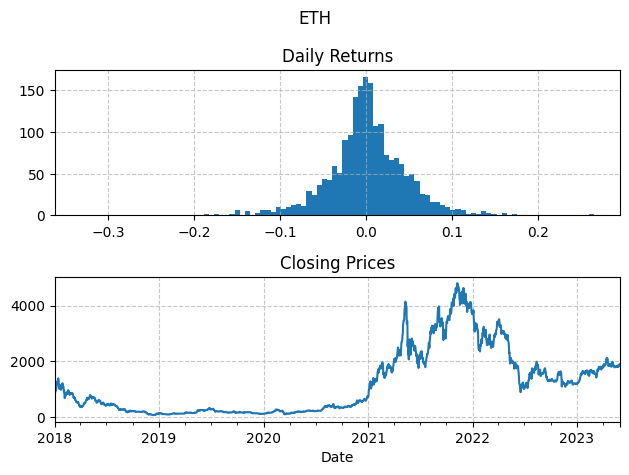

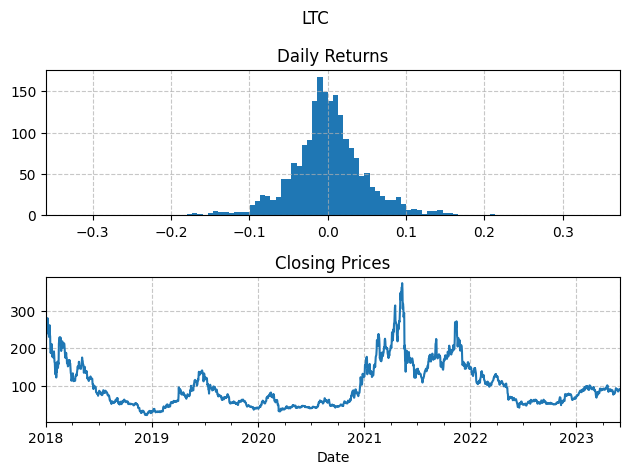

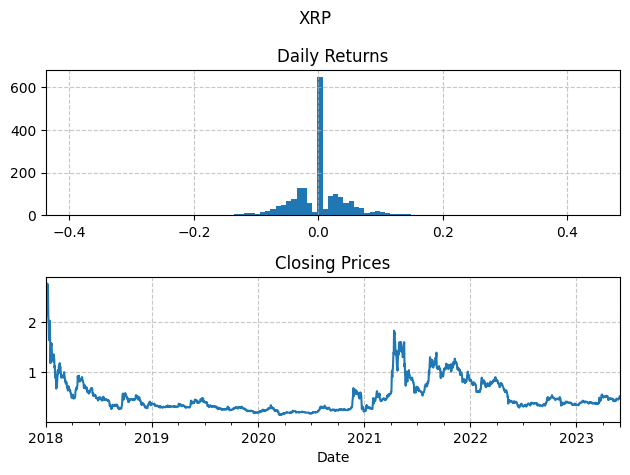

In [3]:
# Plotting the returns and prices for each coin
coins = ['BTC', 'ETH', 'LTC', 'XRP']
for coin in coins:
    coin_returns = f'{coin}__Returns'
    coin_prices = f'{coin}__Close'

    # Appending the new Returns Feature
    data[coin_returns] = data[coin_prices].pct_change()
    plot_returns_and_prices(coin, data[coin_returns], data[coin_prices])

# Droping XRP due to our concerns about data quality.
coins = ['BTC', 'ETH', 'LTC']
data = data.drop(columns=[
    'XRP__Open',
    'XRP__High',
    'XRP__Low',
    'XRP__Close',
    'XRP__Returns',
])

#### Effective feature selection and generation

Predicting expectations of the future based on historical open / high / low / close / returns is quite difficult, some would argue impossible without incorpoating additional exogenous data. We did consider incorporating economic variables such as GDP and CPI, however, we have choosen to use technical indicators derived from historical prices instead. The indcators which we utilize are described below:

- **Volatility**: Also known as standard deviation, scaled by the window size of *n* days.

- **Momentum**: This indicator was developed through our own creativity and its calculation can be seen below. This indicator aims to capture how above or below the closing price is relative to the moving average and volatility.

- **RSI**: Measures the speed and magnitude of a security's recent price changes, it is used by technical traders to assess weather an asset is overbought or oversold. 

<p>Momentum = <sup>(Close - Moving Average)</sup> / <sub>(Moving Average * Volatility)</sub></p>

<p>RSI = 100 - <sup> 100</sup> / <sub>(1 + (Average Gain/ Average loss))</sub></p>


We suspect these technical indicators will provide insight into future prices, but this does come with a small cost in terms of data descruction. We considered using a custom transformer class to address the issue of missing data, however our attempts of this led to poor implemtations when it comes to splitting data into training / validation / testing sets. As a result, we will simply drop the first 40 rows of data which contains missing values.

In [4]:
def calculate_rsi(prices, window=40):
    # Calculate the price differences
    delta = prices.diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the average gain and loss
    avg_gain = gain.rolling(window=window, min_periods=40).mean()
    avg_loss = loss.rolling(window=window, min_periods=40).mean()

    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

def transform_prices(prices, window=40):
    """Function to transform prices into volatility and momentum indicators."""
    features = pd.DataFrame(index=prices.index)

    # Creating the new features
    features['Returns'] = prices.pct_change()    
    features['MovingAverage'] = prices.rolling(window=window).mean()
    features['Volatility'] = features['Returns'].rolling(window=window).std() * np.sqrt(window)
    features['RSI'] = calculate_rsi(prices)

    # Creating the momentum feature
    features['Momentum'] = prices - features['MovingAverage']
    features['Momentum'] /= features['MovingAverage'] * features['Volatility']

    # Droping features which the function should not append
    features = features.drop(columns=['MovingAverage', 'Returns'])

    # Returning the new features
    return features

# Using the function to append new features to the data
for coin in coins:
    features = transform_prices(data[coin + '__Close'])
    data = pd.concat([data, features.add_prefix(f'{coin}__')], axis=1)

data = data.sort_index(axis=1)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1937 entries, 2018-02-10 to 2023-05-31
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BTC__Close       1937 non-null   float64
 1   BTC__High        1937 non-null   float64
 2   BTC__Low         1937 non-null   float64
 3   BTC__Momentum    1937 non-null   float64
 4   BTC__Open        1937 non-null   float64
 5   BTC__RSI         1937 non-null   float64
 6   BTC__Returns     1937 non-null   float64
 7   BTC__Volatility  1937 non-null   float64
 8   ETH__Close       1937 non-null   float64
 9   ETH__High        1937 non-null   float64
 10  ETH__Low         1937 non-null   float64
 11  ETH__Momentum    1937 non-null   float64
 12  ETH__Open        1937 non-null   float64
 13  ETH__RSI         1937 non-null   float64
 14  ETH__Returns     1937 non-null   float64
 15  ETH__Volatility  1937 non-null   float64
 16  LTC__Close       1937 non-null   float64
 

The below code chunk provides a visual of our indicators. We show these charts to provide the reader with insight into how our technical indcators behave overtime. 

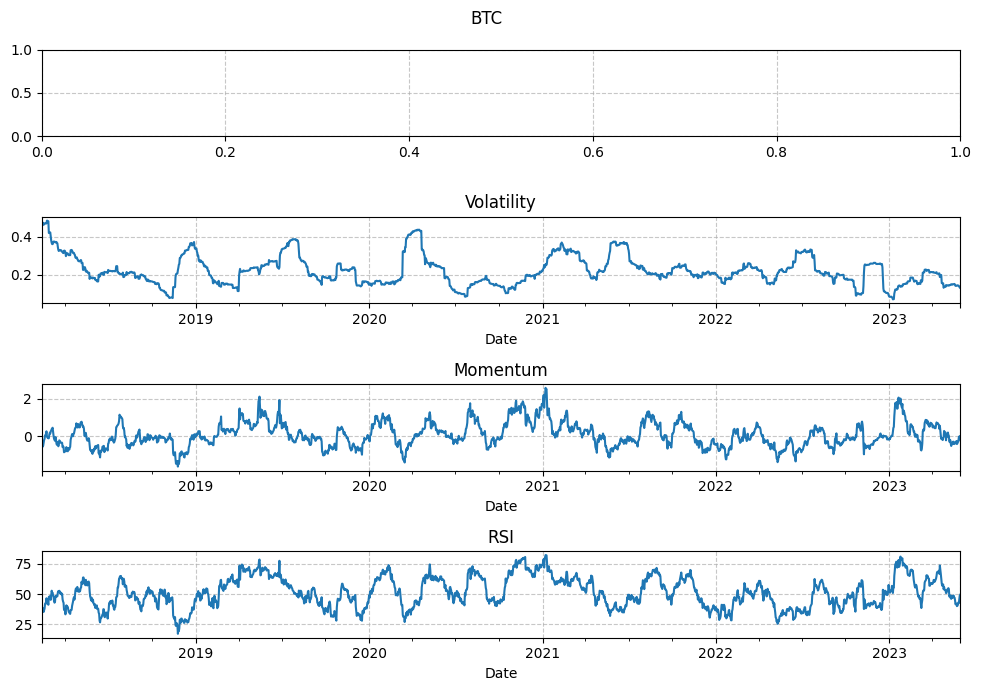

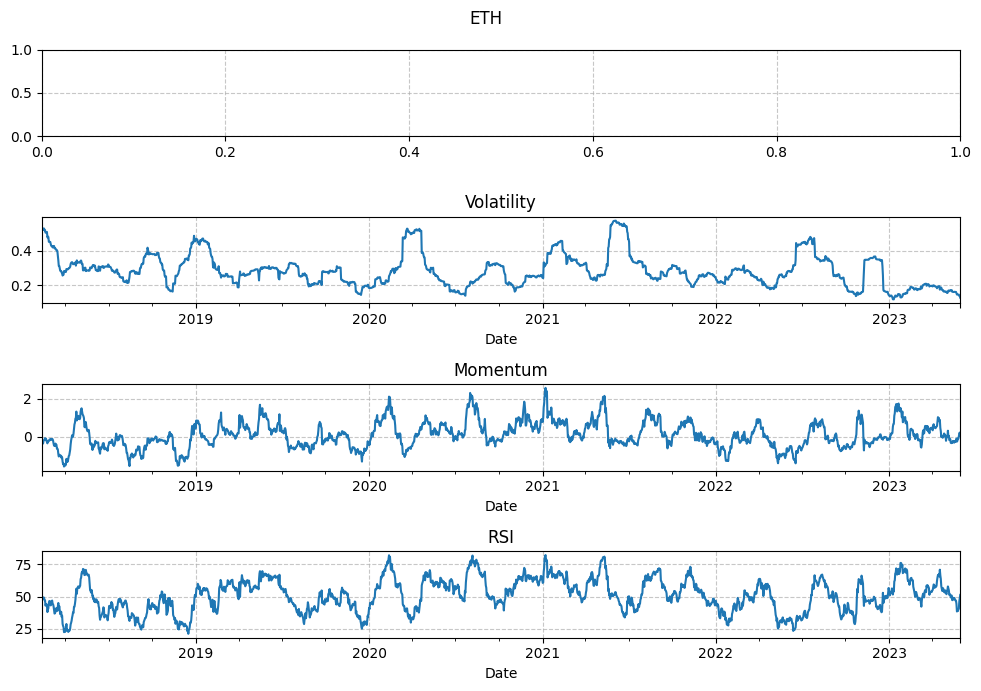

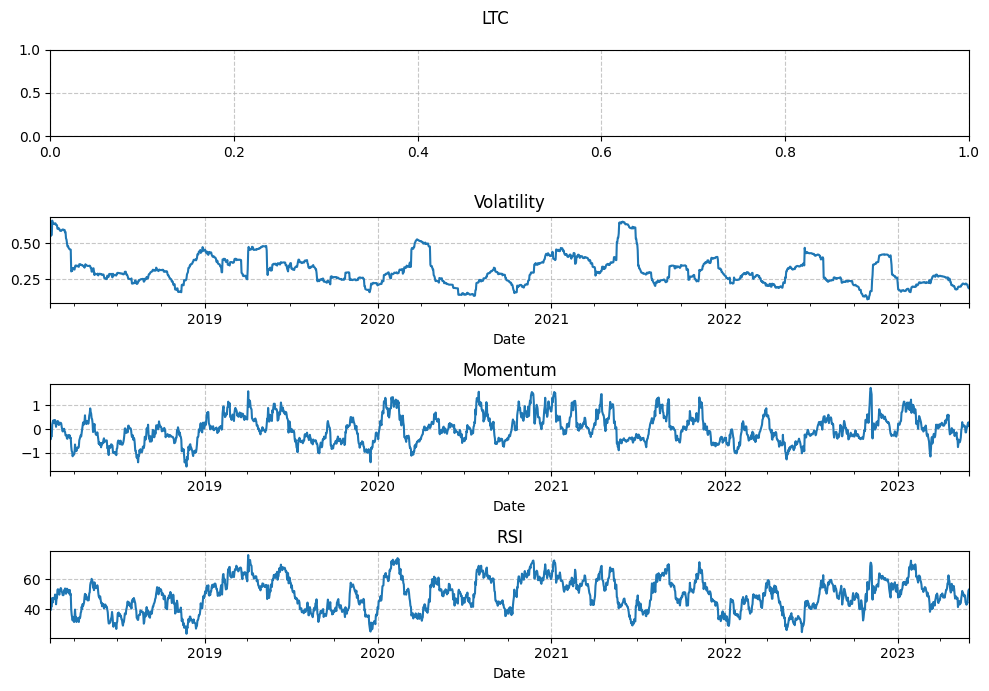

In [5]:
# Plot the technical indicators for each coin against its closing price.
figsize = (10, 7)
for coin in coins:

    # Plot the technical indicators.
    fig, ax = plt.subplots(4, 1, figsize=figsize)
    fig.suptitle(coin)

    # Plot the volatility, momentum, and RSI of each coin.
    data[f'{coin}__Volatility'].plot(ax=ax[1], title='Volatility')
    data[f'{coin}__Momentum'].plot(ax=ax[2], title='Momentum')
    data[f'{coin}__RSI'].plot(ax=ax[3], title='RSI')

    # Apply Grids for all axs
    for axi in ax:
        axi.grid(True, alpha=0.7, linestyle='--')

    plt.tight_layout()
    plt.show()

### 3. Model Selection and Implementation [30 Points]

- Good reasons for choosing models
- Reasonable train/test/validation split
- Clear model training and tuning process

#### Plotting and Analysis Functions


For our analysis / results, we have written the below section of functions to abstract away much of the mundane / reusable code to make our project more readable. 

**Please feel free to the KMeans Regime model if you wish.** 

In [6]:
# Creating a returns dataframe for analysis
returns = pd.DataFrame()
for coin in coins:
    returns[coin] = data[coin + '__Returns']

In [7]:
def analyze_regimes_and_get_best_portfolios(returns, regimes):
    """Function to print the average returns of each coin by regime and return portfolio dictionaries."""

    n_regimes = len(np.unique(regimes))
    regime_returns = returns.loc[regimes.index]

    # Print the average returns of each coin by regime and make a portfolio for each regime
    portfolios_by_regime = {}
    for i in range(n_regimes):
        average_returns = regime_returns[regimes == i].mean()

        print(f'\n-- {average_returns.idxmax()} Best coin in Regime {i}')
        print(average_returns)

        # Add the best portfolio for this regime to the dictionary
        best_coin_index = average_returns.idxmax()
        portfolios_by_regime[i] = [1 if coin == best_coin_index else 0 for coin in average_returns.index]

    # Also print out the best coin overall
    overall_average_returns = returns.mean()
    print(f'\n-- Best Coin Overall: {overall_average_returns.idxmax()}')

    # Create the best overall portfolio
    best_coin_index = overall_average_returns.idxmax()
    best_overall_portfolio = [1 if coin == best_coin_index else 0 for coin in overall_average_returns.index]
    best_overall_portfolio = {i: best_overall_portfolio for i in range(n_regimes)}

    return portfolios_by_regime, best_overall_portfolio

In [8]:
def create_portfolio_timeseries(regimes, portfolio_dict, coins):
    """Function to create a portfolio timeseries from a regime timeseries and portfolio dictionary"""

    # Create a portfolio timeseries
    portfolio = pd.DataFrame(np.zeros((len(regimes), len(coins))), index=regimes.index, columns=coins)
    for regime, allocation in portfolio_dict.items():
        portfolio[regimes == regime] = allocation

    return portfolio

In [9]:
def plot_portfolio_backtest(portfolio, benchmark, returns):
    """Function to plot the cumulative returns of a portfolio and its allocation over time"""

    # Calculate the cumulative returns of the portfolio and benchmark
    portfolio_returns = np.sum(returns * portfolio, axis=1)
    benchmark_returns = np.sum(returns * benchmark, axis=1)

    # Create the figure and axis
    fig, ax = plt.subplots(2, 1, figsize=(8, 5))

    # Plot the cumulative returns of the portfolio and benchmark
    ax[0].set_title('Cumulative Returns')
    (1 + portfolio_returns).cumprod().plot(ax=ax[0], label='Portfolio')
    (1 + benchmark_returns).cumprod().plot(ax=ax[0], label='Benchmark', linestyle='--')
    ax[0].grid(True, alpha=0.7, linestyle='--'), ax[0].legend()

    # Plot the rolling 30-day volatility of the portfolio and benchmark
    ax[1].set_title('Rolling 30-Day Volatility')
    portfolio_returns.rolling(window=30).std().plot(ax=ax[1], label='Portfolio')
    benchmark_returns.rolling(window=30).std().plot(ax=ax[1], label='Benchmark', linestyle='--')
    ax[1].grid(True, alpha=0.7, linestyle='--'), ax[1].legend()

    plt.tight_layout()
    plt.show()

    # Print out simple Sharpe ratio metrics
    portfolio_sharpe = portfolio_returns.mean() / portfolio_returns.std()
    benchmark_sharpe = benchmark_returns.mean() / benchmark_returns.std()
    print('\nSharpe Ratio:')
    print(f'Model: {portfolio_sharpe:.4f}')
    print(f'Benchmark: {benchmark_sharpe:.4f}')

    # Create a plot function which plots the portfolio allocations over time
    if portfolio_sharpe > benchmark_sharpe:
        print('Model Outperformed the benchmark.')
    else:
        print('Model Failed to beat the benchmark.')

In [10]:
def plot_portfolio_allocations(portfolio, benchmark):

    # Create the figure and axis
    fig, ax = plt.subplots(2, 1, figsize=(8, 5))
    fig.suptitle('Model and Benchmark Allocations')

    # Plot the portfolio allocation
    portfolio.plot(ax=ax[0], kind='area', stacked=True)   
    ax[0].set_ylim((0, 1)), ax[0].set_ylabel('Portfolio'), ax[0].legend()
    ax[0].grid(True, alpha=0.7, linestyle='--')

    # Plot the portfolio allocation without x or y axis labels
    benchmark.plot(ax=ax[1], kind='area', stacked=True)
    ax[1].set_ylim((0, 1)), ax[1].set_ylabel('Benchmark'), ax[1].legend()
    ax[1].grid(True, alpha=0.7, linestyle='--')

    plt.tight_layout()
    plt.show()

#### KMeans Persistent Regime Model

For our first model, we will keep things simple and cluster our features using KMeans and assume that our regimes will persist for a single day. Which ever coin had the best performance by regime in the training data, will be the coin we hold during the same regime when testing.  

The first 60% of the data will be used for training and 40% for testing. We have no hyper parameters to tune, so there is no validation set and timeseries data should not be shuffled. Again, our benchmark portfolio will be the best perfoming coin in the testing set. 

##### Building the Model
First we introduce a simple pipeline and apply a robust scaler. The robust scaler is quite helpful in reducing our sensitivity to outliers. 

Lets fit a kmeans model for n_clusters from 2 through 10 to determine the optimal number of clusters.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Create the pipeline to only momentum and volatility columns
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('kmeans', KMeans(n_init=10, random_state=42))
])

# Create an X dataset with only the technical indicators for regime detection
technical_indicators = [coin + '__Momentum' for coin in coins]
technical_indicators += [coin + '__Volatility' for coin in coins]
X = data[technical_indicators]

# Split the data into training and testing sets
X_train, X_test = train_test_split(X, shuffle=False, test_size=0.4)

The below plot of silhouette scores indicates that a 2 regime model is ideal. 

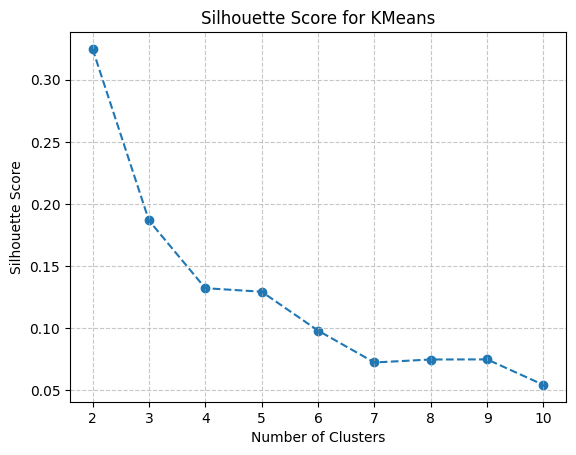

In [12]:
from sklearn.metrics import silhouette_score

# Fit the pipeline to the for n_clusters = {2 - 10} and record silhouette score.
scores = dict()
for n in range(2, 11):
    pipeline.set_params(kmeans__n_clusters=n)
    pipeline.fit(X_train)
    
    # Transform data to get cluster labels
    labels = pipeline['kmeans'].labels_

    # Calculate the silhouette score
    score = silhouette_score(X_train, labels)
    scores[n] = score

# Refitting the model to our best found parameter
n_regimes = 2
pipeline.set_params(kmeans__n_clusters=n_regimes)
pipeline.fit(X_train)

# Plot the scores
fig, ax = plt.subplots()
ax.plot(list(scores.keys()), list(scores.values()), linestyle='--')
ax.scatter(list(scores.keys()), list(scores.values()))
ax.set_title('Silhouette Score for KMeans')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
ax.grid(True, alpha=0.7, linestyle='--')
plt.show()

The below histograms are helpful in determining if the coins exhibit different returns by regime. If they did not, there would not be any point in clustering. 

Analyzing the histograms, it appears that BTC is a better coin to hold in regime 0, while ETH is better to hold in regime 1. In addition, regimes are at least persistent in the training data and appear to be equally likely overall with regime 0 occuring 51% of the time and regime 1 occuring 49% of the time. 


Days In:
Regime 0: 997
Regime 1: 940

Percentage of Time in:
Regime 0: 51.47%
Regime 1: 48.53%

Transition Matrix:
col_0         0         1
row_0                    
0.0    0.956871  0.043129
1.0    0.044728  0.955272


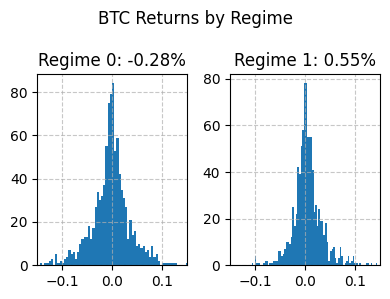

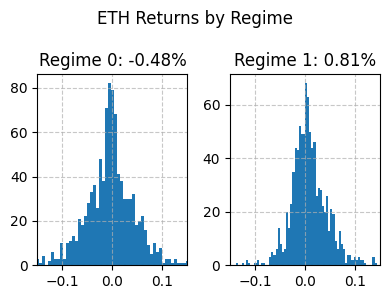

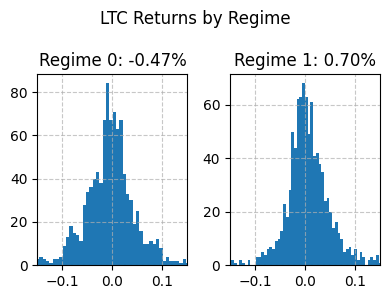

In [13]:
# Assigning a regimes timeseries
regimes = pd.Series(pipeline.predict(X), data.index)
for coin in coins:

    fig, axs = plt.subplots(1, n_regimes, figsize=(2 * n_regimes, 3))
    fig.suptitle(f'{coin} Returns by Regime')

    # Plot a histogram of each regime with the mean return in the title
    for i in range(n_regimes):

        # Filtering down to the coin's returns within the regime
        regime_returns = data.loc[regimes == i, f'{coin}__Returns']

        # Plotting the histogram
        regime_returns.hist(bins=100, ax=axs[i])
        axs[i].set_title(f'Regime {i}: {regime_returns.mean():.2%}')
        axs[i].grid(True, alpha=0.7, linestyle='--')
        axs[i].set_xlim((-0.15, 0.15))

    plt.tight_layout()

# Print the number of days in each regime
print('\nDays In:')
for i in range(n_regimes):
    print(f'Regime {i}: {regimes.value_counts()[i]}')

# Print the percentage of time in each regime
print('\nPercentage of Time in:')
for i in range(n_regimes):
    print(f'Regime {i}: {regimes.value_counts(normalize=True)[i]:.2%}')

# Print a transition matrix. The probability of transitioning from regime a to b
transition_matrix = pd.crosstab(regimes.shift(), regimes, normalize='index')
print('\nTransition Matrix:')
print(transition_matrix)

If we visualize the cluster centers, we can see that regime 0 is best defined as a high volatility low momentum regime while regime 1 has lower volatilty with better momentum. 

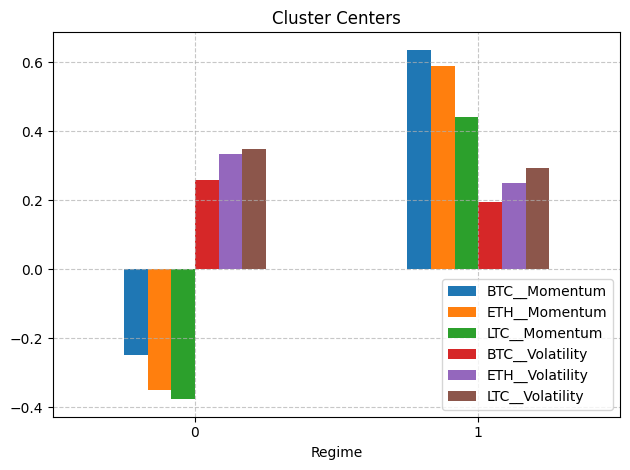

In [14]:

centers = pipeline['kmeans'].cluster_centers_
centers = pd.DataFrame(pipeline['scaler'].inverse_transform(centers), columns=technical_indicators)
centers.index.name = 'Regime'

fig, ax = plt.subplots()
centers.plot(kind='bar', ax=ax)
plt.title('Cluster Centers')
plt.grid(True, alpha=0.7, linestyle='--')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

##### Fit the Model

Here we fit the model print a transition matrix of the test regimes. This shows that our regimes remain persistent in the testing regime.

In [15]:
# Fit the pipeline to the training set and predict both training and test sets.
pipeline.fit(X_train)
regimes_train = pd.Series(pipeline.predict(X_train), X_train.index)
regimes_test = pd.Series(pipeline.predict(X_test), X_test.index)

# Print the transition matrix of the regime test set
transition_matrix = pd.crosstab(regimes_test.shift(1), regimes_test, normalize='index')
print('\nTest Transition Matrix:')
print(transition_matrix)


Test Transition Matrix:
col_0         0         1
row_0                    
0.0    0.950649  0.049351
1.0    0.048843  0.951157


This function prints the best coin to hold by regime. It appears we should hold BTC in regime 0 and ETH in regime 1. 

In [16]:
portfolios, _ = analyze_regimes_and_get_best_portfolios(returns, regimes_train)


-- BTC Best coin in Regime 0
BTC   -0.001743
ETH   -0.004627
LTC   -0.003968
dtype: float64

-- ETH Best coin in Regime 1
BTC    0.007034
ETH    0.009450
LTC    0.008427
dtype: float64

-- Best Coin Overall: ETH


Applying the same function to our testing data, we obtain the benchmark portfolio. ETH is the best coin overall so it is the only coin the benchmark holds.

In [17]:
# During the testing period, ETH was the best overall coin. So our benchmark to beat is a 100% allocation to ETH during the testing period.
_, benchmark = analyze_regimes_and_get_best_portfolios(returns, regimes_test)



-- BTC Best coin in Regime 0
BTC   -0.004414
ETH   -0.004972
LTC   -0.005835
dtype: float64

-- ETH Best coin in Regime 1
BTC    0.003453
ETH    0.006279
LTC    0.005022
dtype: float64

-- Best Coin Overall: ETH


In [18]:
# Formatting our portfolios into a timeseries. Also shifting the portfolios by one day so they may be investable. 
portfolios = create_portfolio_timeseries(regimes_test, portfolios, coins).shift(1)
benchmark = create_portfolio_timeseries(regimes_test, benchmark, coins)

# Also make a set of returns for the backtest
returns_test = benchmark.align(returns, join='inner')[1]



##### Model Backtest

The model has shockingly good results. Beginning the portfolio demonstrates a superior return than the benchmark and does so with less volatility. The daily sharpe ratio is increased from 0.015 to 0.025, this measure is often used in portfolio analysis to indicate a superior portfolio. 

The benefit of KMeans is that it is can at the bare minimum, provide some amount of human insight. In our case, we can say that during periods of high momentum, it is best to own ETH and low momentum periods is is better to own BTC. I would argue that this means BTC is a "risk off" coin which is helpful in turbulent markets while ETH is the coin we should hold once we notice a strong market rally.

The second chart shows our allocation over time, it is a very important chart to review as it represents our portfolio as a timeseries. From the chart, you can see that our regime model recommended a 100% allocation to BTC where shaded in blue (January 2022 for example) and its most recent recommendation was 100% in ETH. The downside to our model, is that it never provides an investor with a 40/40/20 allocation between coins, instead the model always suggests a 100% allocation, simmiliar to a hard max classifier. Investor's will typically avoid 100% allocation, as it is risk to put all of your eggs in a single basket, in later models, we hope address this issue. 

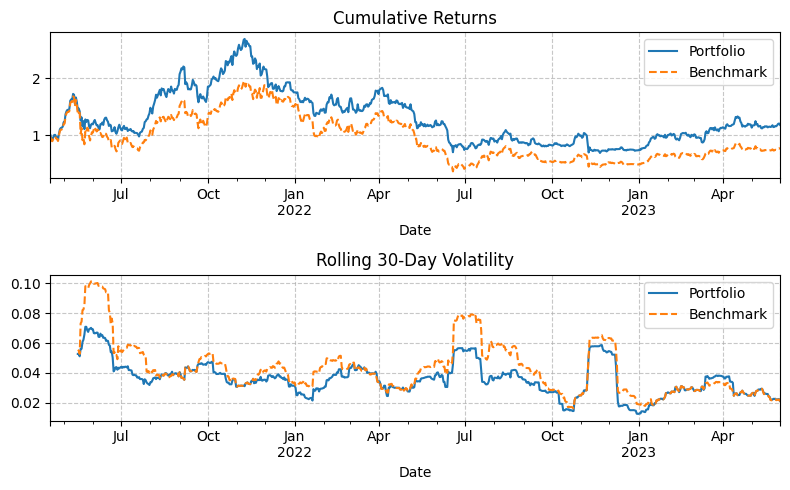


Sharpe Ratio:
Model: 0.0247
Benchmark: 0.0151
Model Outperformed the benchmark.


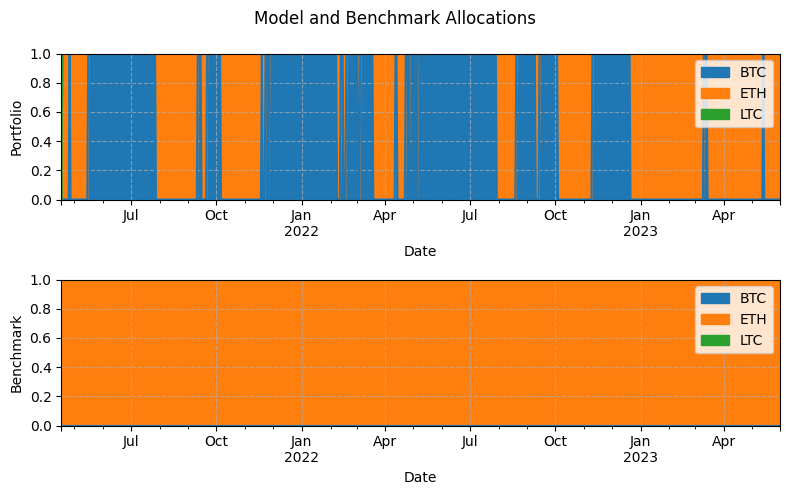

In [19]:
# Plot the portfolio returns and allocation
plot_portfolio_backtest(portfolios, benchmark, returns_test)
plot_portfolio_allocations(portfolios, benchmark)